In [1]:
import matplotlib.pyplot as plt
import torch

from fitting import create_ensemble, load_data, create_datasets
import torch
labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
base_dir = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction/"
save_dir = base_dir + "mse_scale_1_l_1e12"
quad_strengths, image_data, bins, xx = load_data(base_dir, tkwargs)
xx = xx.cpu()

quad_strengths = quad_strengths[:,[0,4,3],:]
image_data = image_data[:,[0,4,3],:]

train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.cuda();


/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
quad_strengths.shape

torch.Size([21, 3, 1])

In [3]:
from phase_space_reconstruction.utils import calculate_ellipse
offset = 0
# calculate rms stats from each image
covs = []
centroids = []
image_data = torch.clip(image_data, offset) - offset
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]
    centroids += [centroid]

covs = torch.stack(covs).detach().cpu()
centroids = torch.stack(centroids)

# plot reconstruction covs
rcovs = []
rcentroids = []
predictions = []
with torch.no_grad():
    for i in range(len(ensemble)):
        print(i)
        en_covs = []
        en_centroids = []
        for j in range(quad_strengths.shape[0]):
            k_covs = []
            k_centroids = []
            for k in range(quad_strengths.shape[1]):
                p, _, _ = ensemble[i](quad_strengths[j,k,:].unsqueeze(1).cuda())
                p = torch.clip(p.cpu(), offset) - offset
                centroid, cov = calculate_ellipse(p.transpose(-2,-1), bins, bins)
                k_covs += [cov]
                k_centroids += [centroid]

                if i==0 and k==0:
                    predictions += [p]
            
                torch.cuda.empty_cache()
            en_covs += [torch.stack(k_covs).squeeze()]
            en_centroids += [torch.stack(k_centroids).squeeze()]
            
        rcovs += [torch.stack(en_covs).squeeze()]
        rcentroids += [torch.stack(en_centroids).squeeze()]
        
rcovs = torch.stack(rcovs).transpose(0,1)
rcovs_mean = rcovs.mean(dim=[1,2])
rcovs_std = rcovs.std(dim=[1,2])
rcentroids = torch.stack(rcentroids).transpose(0,1)


0
1
2
3


In [4]:
print(covs.shape)
print(rcovs.shape)
print(rcentroids.shape)
print(predictions[0].shape)
print(bin_width)

torch.Size([21, 3, 2, 2])
torch.Size([21, 4, 3, 2, 2])
torch.Size([21, 4, 3, 2])
torch.Size([1, 500, 500])
tensor(4.1620e-05)


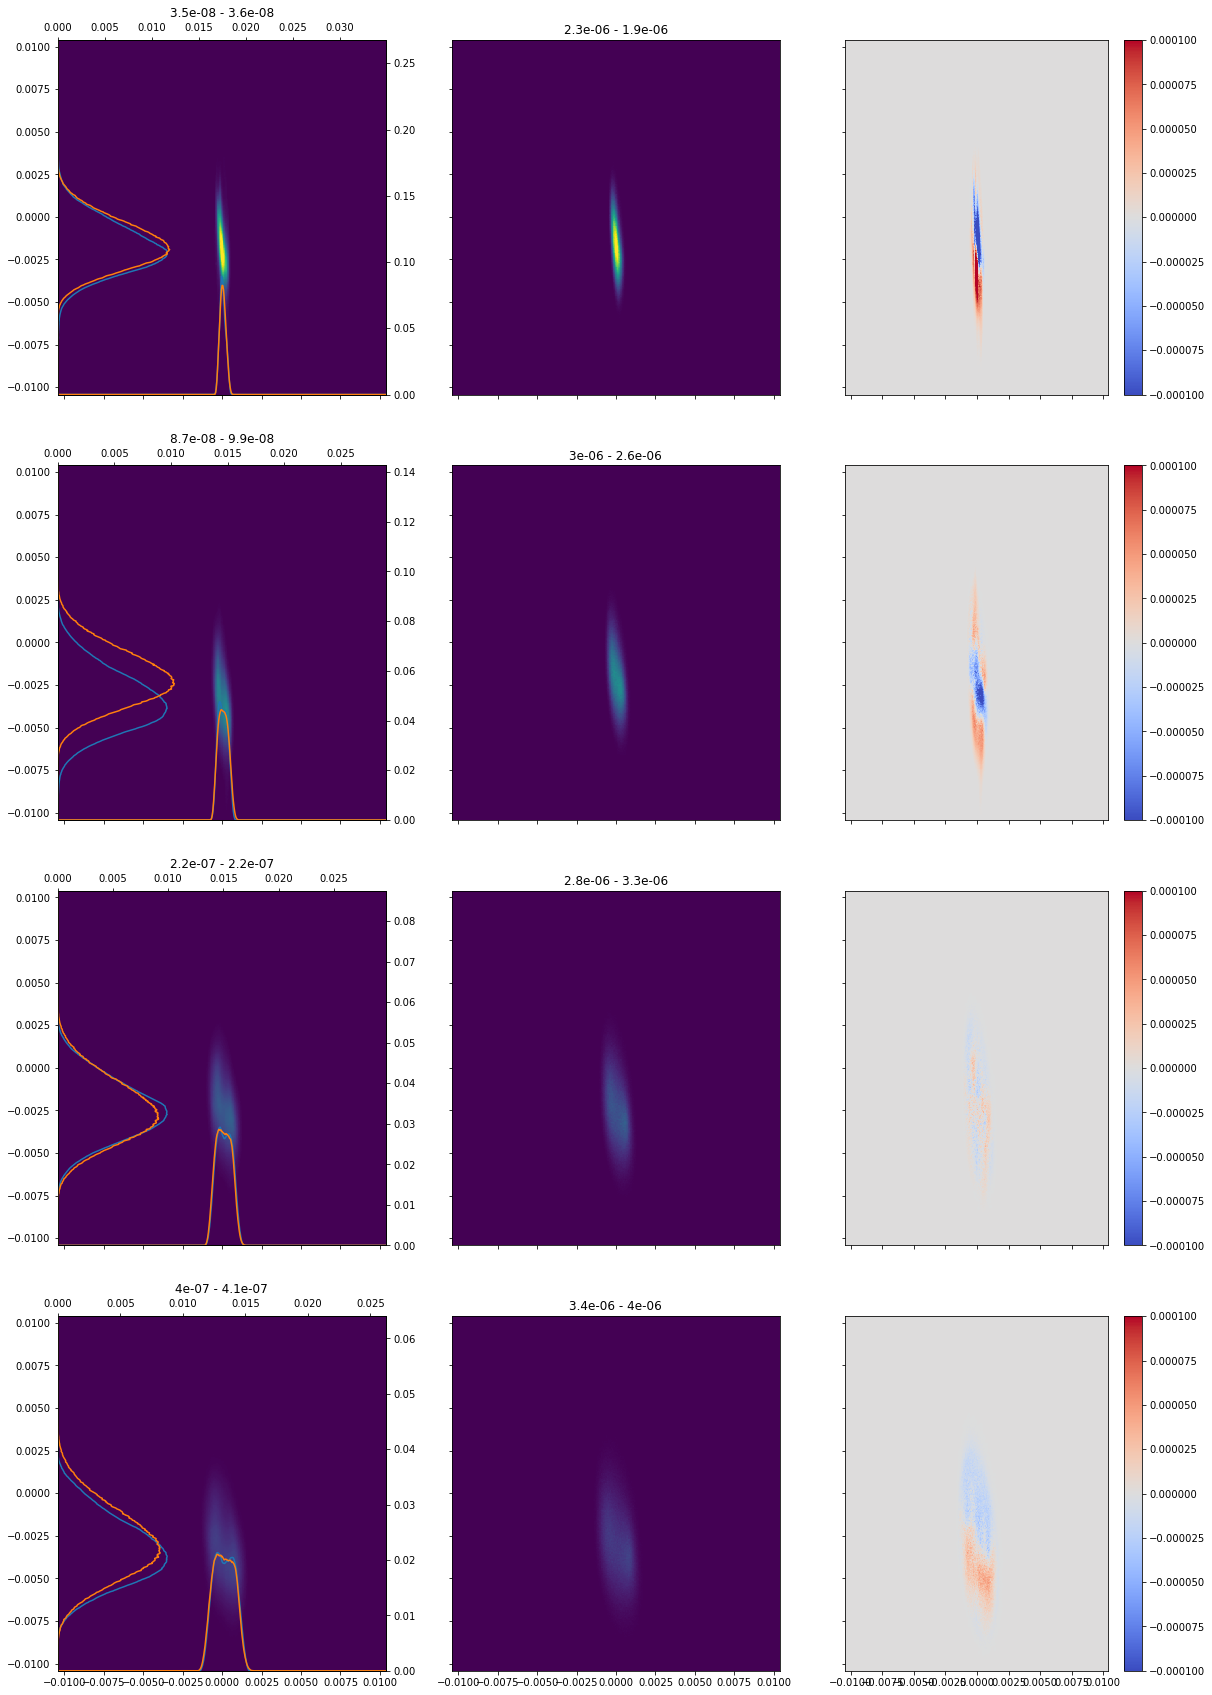

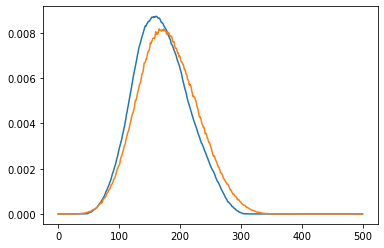

In [5]:
import numpy as np
indicies = np.arange(-5,-1)

fig,ax = plt.subplots(len(indicies),3,sharex="all", sharey="all")
fig.set_size_inches(20,30)
shot_index = 0

vmax = 0.001
for i, index in enumerate(indicies):
    ax[i][0].pcolor(*xx, 
                    image_data[index][shot_index].cpu().detach(),
                    vmin=0,vmax=vmax
                    )
    ax[i][1].pcolor(*xx, 
                    predictions[index][shot_index].cpu().detach(), 
                    vmin=0,vmax=vmax)

    c = ax[i][2].pcolor(*xx,image_data[index].mean(dim=0).cpu().detach() - predictions[index][shot_index].cpu()
                    .detach(),cmap="coolwarm",vmin=-vmax*0.1, vmax=vmax*0.1)
    fig.colorbar(c, ax=ax[i][2])
    axb = ax[i][0].twinx()
    axb.plot(bins, image_data[index][shot_index].sum(dim=-2))
    axb.plot(bins, predictions[index][shot_index].sum(dim=-2))
    axb.set_ylim(0.0, image_data[index][shot_index].sum(dim=-2).max()*3)
    
    axc = ax[i][0].twiny()
    axc.plot(image_data[index][shot_index].sum(dim=-1),bins)
    axc.plot(predictions[index][shot_index].sum(dim=-1),bins)
    axc.set_xlim(0.0, image_data[index][shot_index].sum(dim=-1).max()*3)
    
    axb.set_title(f"{covs[index,shot_index,1,1]:.2} - {rcovs[index,shot_index,0,1,1]:.2}")
    ax[i][1].set_title(f"{covs[index,shot_index,0,0]:.2} - {rcovs[index,shot_index,0,0,0]:.2}")

plt.figure()
plt.plot(image_data[index][shot_index].sum(dim=-1))
plt.plot(predictions[index][shot_index].sum(dim=-1))



In [6]:
# traing scalar model
from phase_space_reconstruction.modeling import NormalizedQuadScan
from torch.nn.functional import mse_loss

# fit phase spaces
train_s11 = covs[...,0,0].detach().cpu().flatten()
train_s22 = covs[...,1,1].detach().cpu().flatten()
models = []

for ele in [train_s11, train_s22]:
    train_k = quad_strengths.flatten().cpu()
    quad_length = torch.tensor(0.12)
    drift = torch.tensor(3.38 - 0.12/2)
    A = train_s11.max().sqrt()

    model = NormalizedQuadScan(A, drift, quad_length)

    optimizer = torch.optim.Adam(
            model.parameters(), lr=0.01
    )

    for i in range(25000):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_k)
        # Calc loss and backprop gradients
        loss = torch.abs(output*1e6 - ele*1e6).mean()
        loss.backward()
        if not i % 2000:
            print(loss)
        optimizer.step()

    models += [model]

    print(model.emittance() * 63.0 / 0.511)

tensor(53.6327, grad_fn=<MeanBackward0>)
tensor(0.1066, grad_fn=<MeanBackward0>)
tensor(0.1008, grad_fn=<MeanBackward0>)
tensor(0.1010, grad_fn=<MeanBackward0>)
tensor(0.1012, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.1013, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.1015, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.1010, grad_fn=<MeanBackward0>)
tensor(0.1011, grad_fn=<MeanBackward0>)
tensor(3.9994e-06, grad_fn=<DivBackward0>)
tensor(53.9534, grad_fn=<MeanBackward0>)
tensor(0.0547, grad_fn=<MeanBackward0>)
tensor(0.0515, grad_fn=<MeanBackward0>)
tensor(0.0511, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0515, grad_fn=<MeanBackward0>)
tensor(0.0507, grad_fn=<MeanBackward0>)
tensor(0.0514, grad_fn=<MeanBackward0>)
tensor(0.0511, grad_fn=<MeanBackward0>)
tensor(0.0508, grad_fn=<MeanBackward0>)
tensor(0.0508, grad_fn=<MeanBackwar

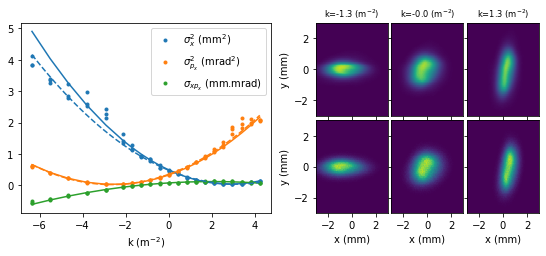

In [7]:
fig = plt.figure(figsize=np.array((8,3.5))*1)
subfigs = fig.subfigures(1,2, wspace=0.0)

ax = subfigs[0].subplots(gridspec_kw={"left":0.1,"right":0.97})

image_ax = subfigs[1].subplots(2,3,sharex="all",sharey="all",gridspec_kw={"hspace":0.05,"wspace":0.05})
#fig,ax = plt.subplots(2,4,sharex="col",gridspec_kw={"width_ratios":[1.0,0.5,0.5,0.5],"hspace":0.05})

test_quad_strength = torch.linspace(quad_strengths.min(), quad_strengths.max(),100)

# plot centroids and covs
#centroid_axis = ax[0,0]
cov_axis = ax
colors = ["C0","C1"]
if 0:
    for i in range(2):
        centroid_axis.plot(
            quad_strengths.detach().cpu().flatten(), 
            centroids[...,i].detach().cpu().flatten()*1e3,
            f".{colors[i]}"
        )

        centroid_axis.plot(
            quad_strengths[:,0,:].detach().cpu().flatten(), 
            rcentroids[:,0,0,i].detach().cpu().flatten()*1e3,
            f"{colors[i]}"
        )

# plot covs
slices = [[0,0],[1,1],[0,1]]

labels = ["$\sigma_x^2$ (mm$^2$)","$\sigma_{p_x}^2$ (mrad$^2$)","$\sigma_{xp_x}$ (mm.mrad)"]
for i in range(3):
    cov_axis.plot(
        quad_strengths.detach().cpu().flatten(),
        covs[...,slices[i][0],slices[i][1]].flatten()*1e6,
        f".C{i}",
        label=labels[i]
    )
    
    cov_axis.plot(
        quad_strengths[:,0,:].detach().cpu().flatten(),
        rcovs_mean[...,slices[i][0],slices[i][1]].flatten()*1e6,
        f"C{i}"
        #rcovs_std[...,slices[i][0],slices[i][1]].flatten()*1e6,
        #capsize=5
    )

for i in range(2):
    with torch.no_grad():
        pred = models[i](test_quad_strength)
        
    cov_axis.plot(test_quad_strength, pred*1e6,f"--C{i}")
ax.legend()
ax.set_xlabel("k (m$^{-2}$)")

indicies = [7,10,13][::-1]
q_strengths = quad_strengths[indicies,0,0]
shot_index = 0

lims = 3
for i, index in enumerate(indicies):
    vmax = torch.stack((image_data[index].mean(dim=0), predictions[index][shot_index])).max()*1.1
    
    image_ax[0][i].pcolor(*xx*1e3, 
                    image_data[index].mean(dim=0).cpu().detach().T,
                    vmax=vmax
                    )
    image_ax[0][i].set_xlim(-lims,lims)
    image_ax[0][i].set_ylim(-lims,lims)

    image_ax[1][i].pcolor(*xx*1e3, 
                    predictions[index][shot_index].cpu().detach().T,
                    vmax=vmax)
    image_ax[0][i].set_title(f"k={q_strengths[i].numpy():.2} (m$^{{-2}}$)", fontsize="small")
    
for ele in image_ax[:,0]:
    ele.set_ylabel("y (mm)")
    ele.set_yticks([-2,0,2])
for ele in image_ax[-1,:]:
    ele.set_xlabel("x (mm)")
    ele.set_xticks([-2,0,2])
    
fig.savefig("rms_analysis.png",dpi=300)

In [8]:
# do bayesian linear regression using pyro
import pyro
from pyro import poutine

from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoNormal

class PyroNormalizedQuadScan(NormalizedQuadScan, PyroModule):
    def forward(self, k, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.05))
        mean = super().forward(k)*1e6
        with pyro.plate("data", k.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean



model = PyroNormalizedQuadScan(A, drift, quad_length)
model.lambda_1 = PyroSample(dist.Normal(1.0,5.0))
model.lambda_2 = PyroSample(dist.Normal(1.0,5.0))
model.c = PyroSample(dist.Normal(0.0,5.0))

posterior_module = pyro.nn.PyroModule("model")
posterior_module.guide = AutoNormal(poutine.block(model, hide=['bm']))


print(dict(model.named_parameters()))

ModuleNotFoundError: No module named 'pyro'

In [ ]:
from pyro.infer import SVI, Trace_ELBO

def train(model, guide, *args, lr=0.001, n_steps=201, verbose=False):
    pyro.clear_param_store()
    initial_lr = lr
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
    svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

    losses = []
    for step in range(n_steps):
        loss = svi.step(*args)
        losses.append(loss)
        if step % 50 == 0 and verbose:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

    return losses

losses= train(
    model,posterior_module.guide, train_k, train_s22*1e6,
    lr=0.01,n_steps=4000, verbose=True
)
plt.plot(losses)

In [ ]:
posterior_predictive = Predictive(model, num_samples=800, parallel=True,
                               guide=posterior_module.guide)
test_k = torch.linspace(train_k.min(),train_k.max(),100)

posterior_samples = posterior_predictive(test_k)

def get_stats(samples):
    mean = torch.mean(samples, dim=0)
    l = torch.quantile(samples, 0.05, dim=0)
    u = torch.quantile(samples, 0.95, dim=0)
    return mean, l, u

fig, ax = plt.subplots()
m, l, u = get_stats(posterior_samples["obs"].squeeze()/1e6)
ax.plot(test_k.squeeze().cpu(), m.cpu())
ax.fill_between(test_k.squeeze().cpu(), l.cpu(), u.cpu(), alpha=0.25)

ax.plot(train_k.squeeze().cpu(), train_s22.squeeze().cpu(), '.')

In [ ]:
emittances = []
for i in range(10000):
    emittances+=[model.emittance()]
emittances = torch.tensor(emittances)
qs = torch.quantile(emittances, torch.tensor([0.05,0.5-0.34,0.5,0.5+0.34,0.95]))
print(qs)
plt.hist(emittances,bins=100);